In [39]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [40]:
train_dir = '/kaggle/input/fer2013/train'
classes = os.listdir(train_dir)
print(classes)

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [41]:
dataset = ImageFolder(train_dir, transform=ToTensor())

In [42]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 48, 48]) 0


tensor([[[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]],

        [[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]],

        [[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.

In [43]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  happy (3)


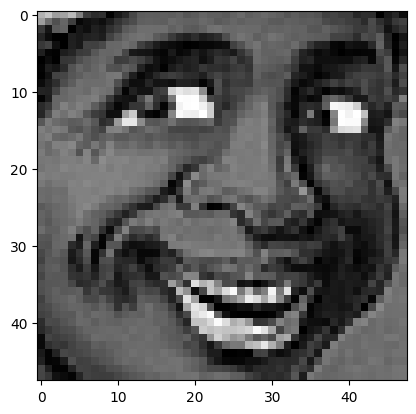

In [44]:
show_example(*dataset[11802])

In [45]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(48, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [46]:
batch_size=500

In [47]:
train_ds = ImageFolder('/kaggle/input/fer2013/train', train_tfms)
valid_ds = ImageFolder('/kaggle/input/fer2013/train', valid_tfms)

In [48]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [49]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

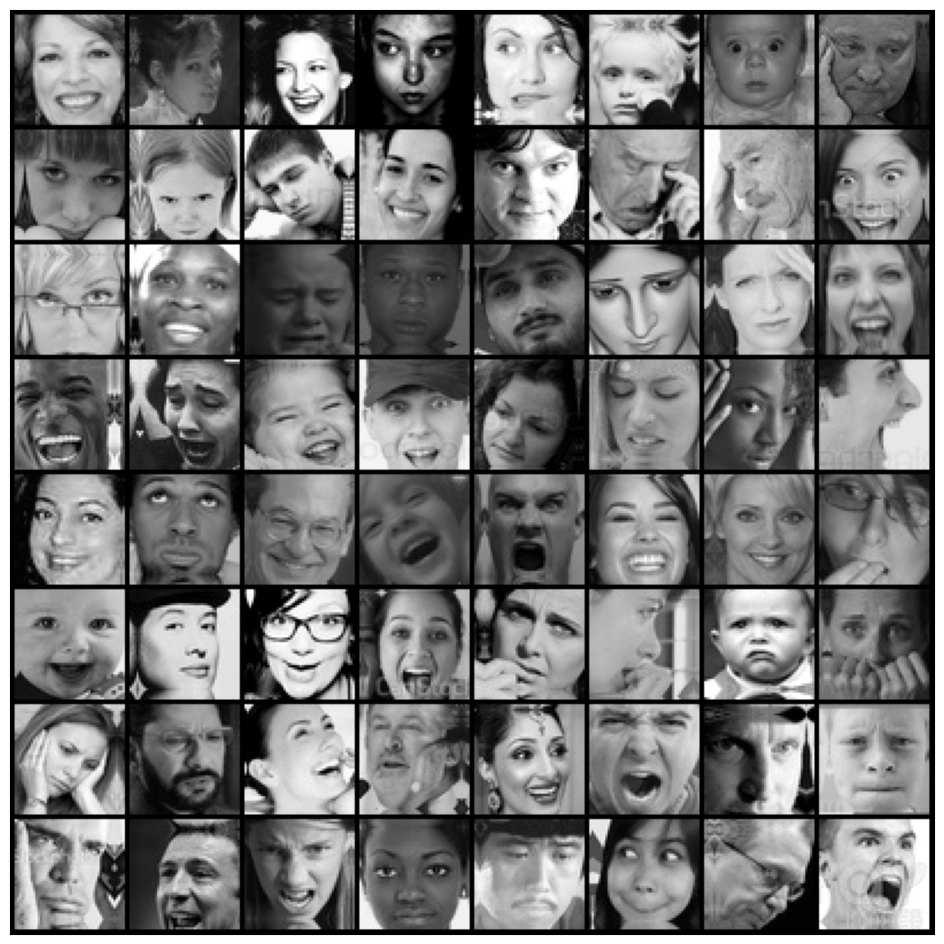

In [50]:
show_batch(train_dl)

In [51]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):

        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):

        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cuda')

In [53]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [54]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [55]:
# import torch
# import torch.nn as nn

# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
        
#         # Layer 1
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # Layer 2
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # Layer 3
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#             # Layer 4
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#             # Layer 5
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
        
#         # Fully connected layers
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), 256 * 6 * 6)
#         x = self.classifier(x)
#         return x

# # Create an instance of AlexNet
# alexnet = AlexNet(num_classes=1000)

# # Print the architecture
# print(alexnet)


In [75]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

import torch.nn as nn

#This modified architecture follows a structure similar to AlexNet with 
#five convolutional layers and three fully connected layers

class EmotionDetectionModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super(EmotionDetectionModel, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)

        # Layer 4
        self.conv4 = nn.Conv2d(384, 768, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        # Layer 5
        self.conv5 = nn.Conv2d(768, 768, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(768 * 2 * 2, 4096)  # Adjust the input size
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(4096, 4096)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.relu5(x)

        # Flatten
        x = x.view(x.size(0), 768 * 2 * 2)  # Adjust the size according to the actual size before flattening

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu7(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

# Create an instance of EmotionAlexNet
#emotion_alexnet = EmotionAlexNet(in_channels=3, num_classes=7)

# Print the architecture
#print(emotion_alexnet)


In [76]:
model = to_device(EmotionDetectionModel(3, 7), device)
model

EmotionDetectionModel(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (fc1): Linear(in_features=3072, out_features=4096, bias=True)
  (relu6): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (relu7): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, i

In [77]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [78]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9467031955718994, 'val_acc': 0.11948096007108688}]

In [81]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [82]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 1.9134, test_loss: 1.8236, test_acc: 0.2488
Epoch [1], last_lr: 0.00008, train_loss: 1.8128, test_loss: 1.7941, test_acc: 0.2516
Epoch [2], last_lr: 0.00010, train_loss: 1.7837, test_loss: 1.7359, test_acc: 0.2854
Epoch [3], last_lr: 0.00010, train_loss: 1.7276, test_loss: 1.6684, test_acc: 0.3364
Epoch [4], last_lr: 0.00008, train_loss: 1.6790, test_loss: 1.6098, test_acc: 0.3603
Epoch [5], last_lr: 0.00006, train_loss: 1.6301, test_loss: 1.5802, test_acc: 0.3658
Epoch [6], last_lr: 0.00004, train_loss: 1.5972, test_loss: 1.5564, test_acc: 0.3755
Epoch [7], last_lr: 0.00002, train_loss: 1.5901, test_loss: 1.5361, test_acc: 0.3814
Epoch [8], last_lr: 0.00000, train_loss: 1.5721, test_loss: 1.5290, test_acc: 0.3890
Epoch [9], last_lr: 0.00000, train_loss: 1.5665, test_loss: 1.5282, test_acc: 0.3885


In [93]:
# Assuming `model` is your trained model
test_results = evaluate(model, valid_dl)
final_accuracy = test_results['val_acc']
print(f'Final Accuracy: {final_accuracy:.4f}')

Final Accuracy: 0.3885


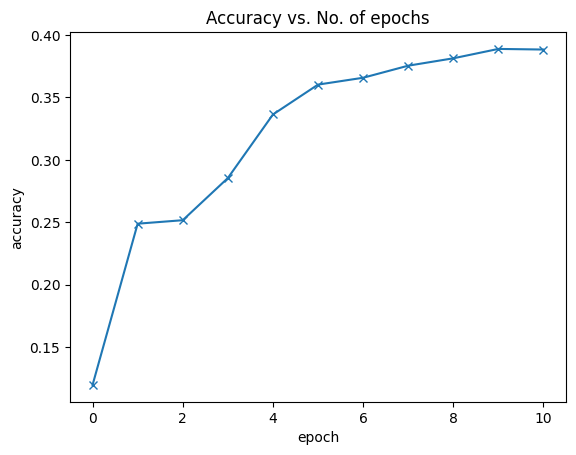

In [83]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

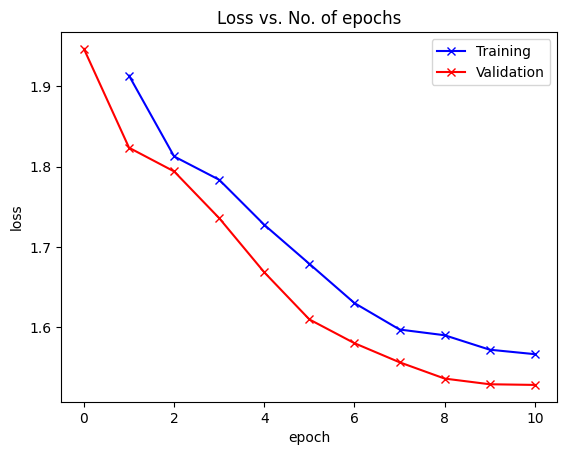

In [84]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

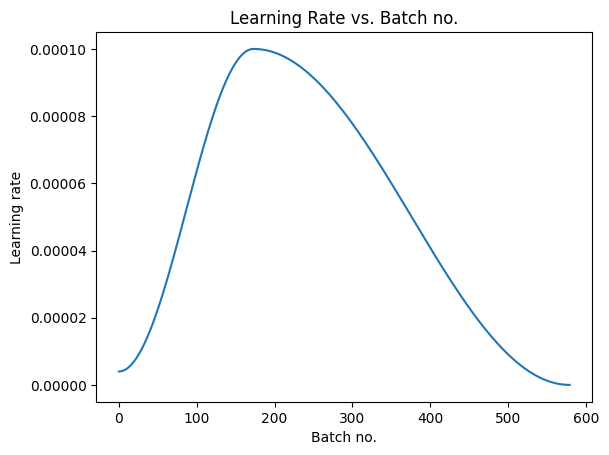

In [85]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

Label: angry , Predicted: happy


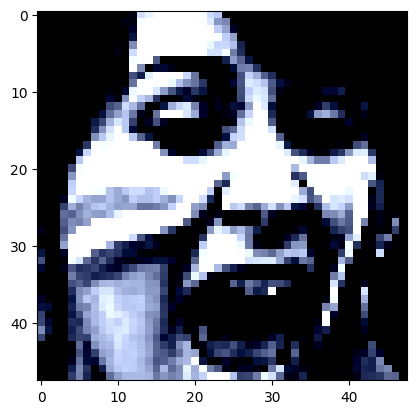

In [86]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

img, label = valid_ds[139]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: sad


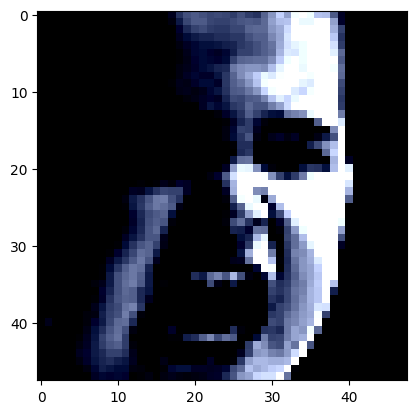

In [87]:
img, label = valid_ds[2200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: angry , Predicted: neutral


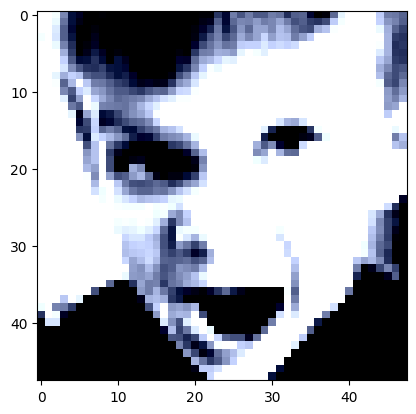

In [88]:
img, label = valid_ds[1390]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: happy , Predicted: surprise


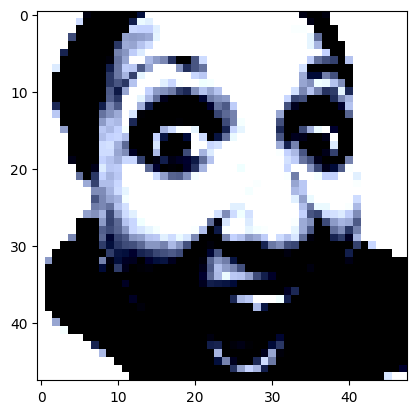

In [89]:
img, label = valid_ds[11201]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: surprise , Predicted: surprise


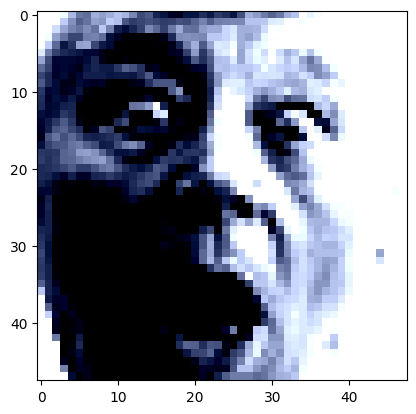

In [90]:
img, label = valid_ds[28708]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))